In [5]:
# Route A - Cell 1: Load data and create train/val/test splits

import pandas as pd

# 载入并转换 datetime
df = pd.read_csv("SeoulBikeDataClean.csv", parse_dates=['datetime'])

# 仅保留 functioning_day == Yes
df = df[df['functioning_day'] == 'Yes'].copy()

# 时间切分
df['date_only'] = df['datetime'].dt.date
train_df = df[df['datetime'] < '2018-10-01']
val_df   = df[(df['datetime'] >= '2018-10-01') & (df['datetime'] < '2018-11-01')]
test_df  = df[df['datetime'] >= '2018-11-01']

print("✅ Data split complete:")
print(f"Train set: {train_df.shape}")
print(f"Validation set: {val_df.shape}")
print(f"Test set: {test_df.shape}")


✅ Data split complete:
Train set: (7152, 24)
Validation set: (665, 24)
Test set: (648, 24)


In [6]:
# Route A - Cell 2 (最终兼容版本): 使用原生 xgboost.train() 实现 early stopping

import xgboost as xgb
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# 特征定义
numeric_features = ['temperaturec', 'temperaturec_squared', 'solar_radiation_mj_m2']
categorical_features = [
    'hour', 'seasons', 'is_raining', 'is_snowing',
    'is_holiday', 'is_working_day', 'functioning_day'
]

# 提取特征和目标
X_train = train_df[numeric_features + categorical_features]
y_train = train_df['rented_bike_count']
X_val = val_df[numeric_features + categorical_features]
y_val = val_df['rented_bike_count']

# 预处理器
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc = preprocessor.transform(X_val)

# 转为 DMatrix 格式
dtrain = xgb.DMatrix(X_train_proc, label=y_train)
dval = xgb.DMatrix(X_val_proc, label=y_val)

# 参数配置
params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'eta': 0.05,
    'eval_metric': 'rmse',
    'seed': 42
}

# 训练并使用早停
watchlist = [(dtrain, 'train'), (dval, 'eval')]
xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    evals=watchlist,
    early_stopping_rounds=10
)

print("✅ Model training complete.")


[0]	train-rmse:632.15739	eval-rmse:667.58734
[1]	train-rmse:611.98138	eval-rmse:656.65073
[2]	train-rmse:593.07718	eval-rmse:648.60725
[3]	train-rmse:575.28032	eval-rmse:641.90153
[4]	train-rmse:558.56072	eval-rmse:636.04885
[5]	train-rmse:541.04428	eval-rmse:625.51656
[6]	train-rmse:526.37452	eval-rmse:616.96076
[7]	train-rmse:512.10850	eval-rmse:610.43513
[8]	train-rmse:499.23951	eval-rmse:603.15416
[9]	train-rmse:486.97755	eval-rmse:593.79950
[10]	train-rmse:475.68996	eval-rmse:590.42097
[11]	train-rmse:463.55374	eval-rmse:585.68307
[12]	train-rmse:452.77920	eval-rmse:582.32083
[13]	train-rmse:443.06209	eval-rmse:577.37370
[14]	train-rmse:432.51630	eval-rmse:574.32874
[15]	train-rmse:423.52641	eval-rmse:572.87309
[16]	train-rmse:412.65977	eval-rmse:569.18365
[17]	train-rmse:402.62750	eval-rmse:565.14391
[18]	train-rmse:394.77428	eval-rmse:564.18697
[19]	train-rmse:387.54328	eval-rmse:563.42737
[20]	train-rmse:378.52466	eval-rmse:560.77420
[21]	train-rmse:372.54533	eval-rmse:558.7797

📊 Test RMSE: 398.12
📈 Test R²: 0.2360


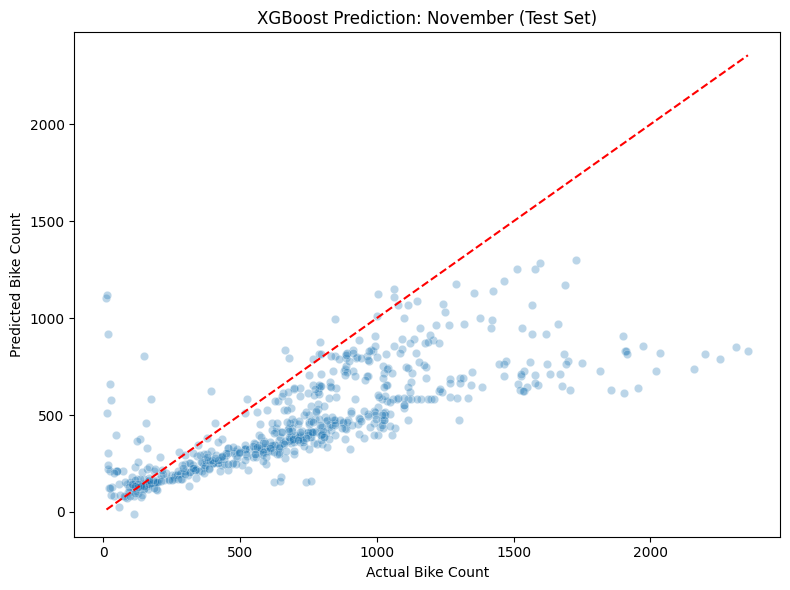

In [8]:
# Route A - Cell 3 (修复版): 评估 test set 上的最终表现

from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

# 准备 test 数据
X_test = test_df[numeric_features + categorical_features]
y_test = test_df['rented_bike_count']
X_test_proc = preprocessor.transform(X_test)
dtest = xgb.DMatrix(X_test_proc)

# 使用训练好的原生模型预测
y_pred_test = xgb_model.predict(dtest)

# 评估
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
r2_test = r2_score(y_test, y_pred_test)

print(f"📊 Test RMSE: {rmse_test:.2f}")
print(f"📈 Test R²: {r2_test:.4f}")

# 可视化
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_test, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Bike Count")
plt.ylabel("Predicted Bike Count")
plt.title("XGBoost Prediction: November (Test Set)")
plt.tight_layout()
plt.show()



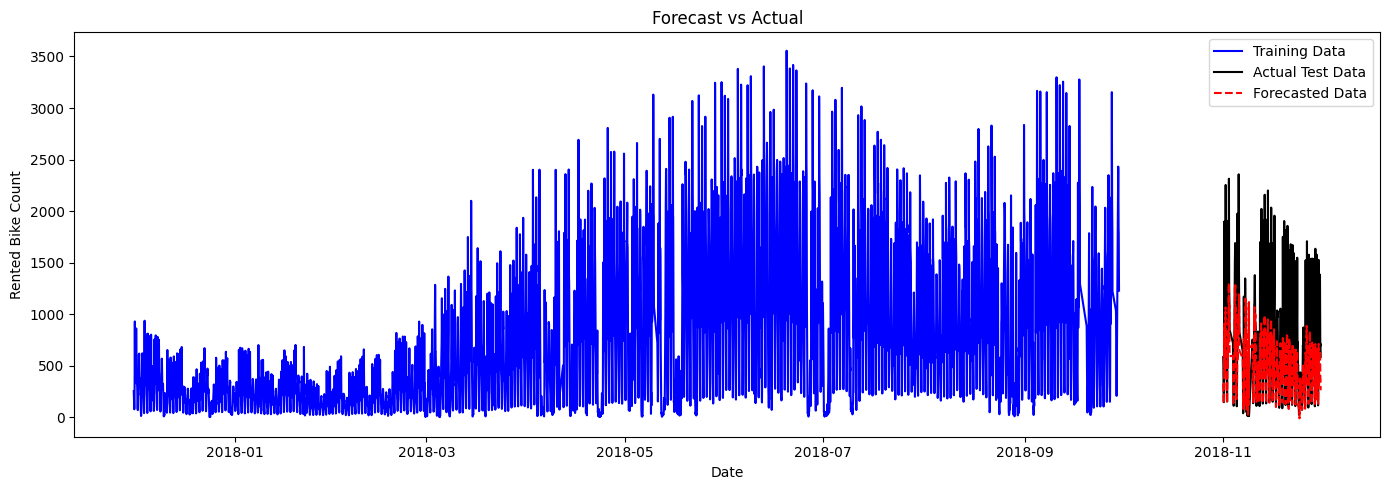

In [9]:
# 可视化预测 vs 实际（训练 + 测试）

import matplotlib.pyplot as plt
import pandas as pd

# 准备数据：带预测值
train_plot_df = train_df[['datetime', 'rented_bike_count']].copy()
train_plot_df['source'] = 'train'

test_plot_df = test_df[['datetime', 'rented_bike_count']].copy()
test_plot_df['predicted'] = y_pred_test
test_plot_df['source'] = 'test'

# 合并
combined_df = pd.concat([train_plot_df, test_plot_df], axis=0)

# 开始绘图
plt.figure(figsize=(14, 5))

# 训练集真实值（蓝色实线）
plt.plot(train_plot_df['datetime'], train_plot_df['rented_bike_count'], label='Training Data', color='blue')

# 测试集真实值（黑色实线）
plt.plot(test_plot_df['datetime'], test_plot_df['rented_bike_count'], label='Actual Test Data', color='black')

# 测试集预测值（红色虚线）
plt.plot(test_plot_df['datetime'], test_plot_df['predicted'], label='Forecasted Data', color='red', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Rented Bike Count')
plt.title('Forecast vs Actual')
plt.legend()
plt.tight_layout()
plt.show()
